In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import yfinance as yf
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.stats import norm
from IPython.display import display, HTML
import plotly.graph_objs as go

In [40]:
initial_amount = 10000 #Ten thousand BRL. 
tickers = ["TAEE3.SA"]
yf.pdr_override()
start_date = "2023-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')
data = round(web.get_data_yahoo(tickers, start=start_date, end=end_date), 2)
short_window = 7
long_window = 90


data['SMA_Short'] = data['Close'].rolling(window=short_window).mean().round(2)
data['SMA_Long'] = data['Close'].rolling(window=long_window).mean().round(2)

data['EMA_Short'] = data['Close'].ewm(span=short_window).mean().round(2)
data['EMA_Long'] = data['Close'].ewm(span=long_window).mean().round(2)
data.dropna(inplace=True)
data.iloc[:, :8].head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,SMA_Short,SMA_Long
Date,,,,,,,,
2023-05-12,12.31,12.46,12.00,12.36,11.15,155000,12.10,11.84
2023-05-15,12.33,12.45,12.30,12.34,11.13,67700,12.18,11.85
2023-05-16,12.35,12.45,12.28,12.34,11.13,74200,12.23,11.86
2023-05-17,12.30,12.44,12.28,12.33,11.12,75100,12.28,11.87
2023-05-18,12.33,12.49,12.28,12.37,11.16,115000,12.32,11.88


In [48]:
str_mode = "SMA"
str_short = "SMA_Short"
str_long = "SMA_Long"

# Lógica para os buy signals
buy_signals = (data[str_short] > data[str_long]) & (data[str_short].shift(1) <= data[str_long].shift(1))
sell_signals = (data[str_short] < data[str_long]) & (data[str_short].shift(1) >= data[str_long].shift(1))

# Criação da coluna 'Buy_Signal' com 1 para buy signal e 0 caso contrário
data['Buy_Signal'] = np.where(buy_signals, 1, 0)
data['Sell_Signal'] = np.where(sell_signals, -1, 0)

In [49]:
data['Recommend'] = 0
data.loc[data['Buy_Signal'] == 1, 'Recommend'] = 1
data.loc[data['Sell_Signal'] == -1, 'Recommend'] = -1
data = data.drop(['Buy_Signal', 'Sell_Signal'], axis=1)
data[['Recommend']].value_counts()

Recommend
 0           296
-1             3
 1             1
Name: count, dtype: int64

In [72]:
data.loc[data.index[2], 'Recommend'] = 1
data.loc[data.index[8], 'Recommend'] = -1
data['Profit'] = 0
data

,Open,High,Low,Close,Adj Close,Volume,SMA_Short,SMA_Long,EMA_Short,EMA_Long,Recommend,Profit
Date,,,,,,,,,,,,
2023-05-12,12.31,12.46,12.00,12.36,11.15,155000,12.10,11.84,12.16,11.85,0,0
2023-05-15,12.33,12.45,12.30,12.34,11.13,67700,12.18,11.85,12.20,11.86,0,0
2023-05-16,12.35,12.45,12.28,12.34,11.13,74200,12.23,11.86,12.24,11.87,1,0
2023-05-17,12.30,12.44,12.28,12.33,11.12,75100,12.28,11.87,12.26,11.88,0,0
2023-05-18,12.33,12.49,12.28,12.37,11.16,115000,12.32,11.88,12.29,11.90,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-17,11.68,11.68,11.59,11.62,11.62,64800,11.59,11.62,11.58,11.57,0,0
2024-07-18,11.62,11.65,11.47,11.50,11.50,128500,11.59,11.62,11.56,11.57,0,0
2024-07-19,11.45,11.48,11.25,11.29,11.29,194100,11.56,11.61,11.49,11.56,0,0


In [77]:
buy_price = 0 
in_position = False 
num_stocks = 0

for index, row in data.iterrows():
    if row['Recommend'] == 1 and not in_position:
        buy_price = row['Adj Close']
        in_position = True 
        num_stocks = int(initial_amount/buy_price)

    elif row['Recommend'] == -1 and in_position:
        sell_price = row['Adj Close']
        data.at[index, 'Profit'] = (sell_price - buy_price) * num_stocks
        in_position = False 

data.Profit.sum().round(2) 

233.48

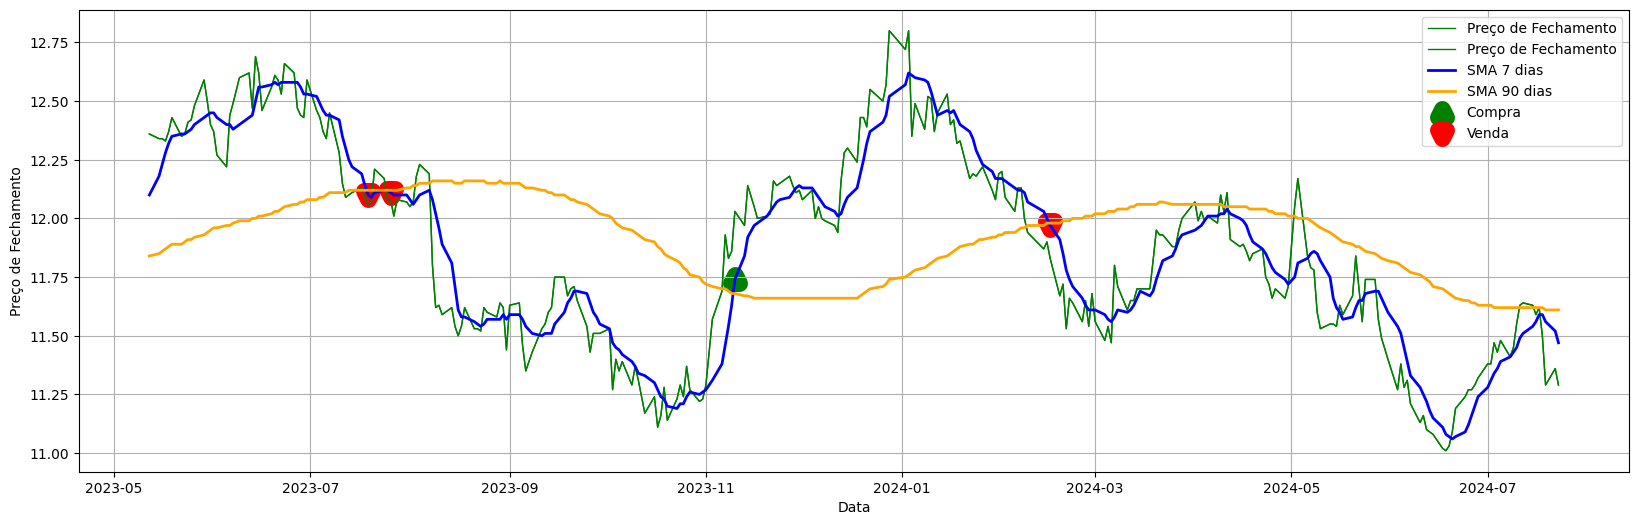

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['Close'], label='Preço de Fechamento', linewidth=1, color='green')
plt.plot(data.index, data['Close'], label='Preço de Fechamento', linewidth=1, color='green')
plt.plot(data.index, data['SMA_Short'], label=f'SMA {short_window} dias', linewidth=2, color='blue')
plt.plot(data.index, data['SMA_Long'], label=f'SMA {long_window} dias', linewidth=2, color='orange')
str_short = "SMA_Short"
str_long = "SMA_Long"
buy_signals = data[(data[str_short] > data[str_long]) & (data[str_short].shift(1) <= data[str_long].shift(1))]
sell_signals = data[(data[str_short] < data[str_long]) & (data[str_short].shift(1) >= data[str_long].shift(1))]
plt.scatter(buy_signals.index, data.loc[buy_signals.index, str_short], marker='^', color='green', linewidth=12, label='Compra')
plt.scatter(sell_signals.index, data.loc[sell_signals.index, str_short], marker='v', color='red', linewidth=12, label='Venda')


plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.grid(True)
plt.show()

# 2. Defining Functions

In [92]:
def backtest_sma(ticker, start_date, end_date, short_window, long_window, show_graph):
    yf.pdr_override()
    start_date = "2023-01-01"
    end_date = datetime.today().strftime('%Y-%m-%d')
    data = round(web.get_data_yahoo(ticker, start=start_date, end=end_date), 2)
    short_window = 7
    long_window = 90


    data['SMA_Short'] = data['Close'].rolling(window=short_window).mean().round(2)
    data['SMA_Long'] = data['Close'].rolling(window=long_window).mean().round(2)

    data['EMA_Short'] = data['Close'].ewm(span=short_window).mean().round(2)
    data['EMA_Long'] = data['Close'].ewm(span=long_window).mean().round(2)
    data.dropna(inplace=True)

    str_short = "SMA_Short"
    str_long = "SMA_Long"

    # Lógica para os buy signals
    buy_signals = (data[str_short] > data[str_long]) & (data[str_short].shift(1) <= data[str_long].shift(1))
    sell_signals = (data[str_short] < data[str_long]) & (data[str_short].shift(1) >= data[str_long].shift(1))

    # Criação da coluna 'Buy_Signal' com 1 para buy signal e 0 caso contrário
    data['Buy_Signal'] = np.where(buy_signals, 1, 0)
    data['Sell_Signal'] = np.where(sell_signals, -1, 0)


    data['Recommend'] = 0
    data.loc[data['Buy_Signal'] == 1, 'Recommend'] = 1
    data.loc[data['Sell_Signal'] == -1, 'Recommend'] = -1
    data = data.drop(['Buy_Signal', 'Sell_Signal'], axis=1)
    data['Profit'] = 0
    buy_price = 0 
    in_position = False 
    num_stocks = 0

    for index, row in data.iterrows():
        if row['Recommend'] == 1 and not in_position:
            buy_price = row['Adj Close']
            in_position = True 
            num_stocks = int(initial_amount/buy_price)

        elif row['Recommend'] == -1 and in_position:
            sell_price = row['Adj Close']
            data.at[index, 'Profit'] = int((sell_price - buy_price) * int(num_stocks))
            in_position = False

    print(f"Profit obtained: BRL {data['Profit'].sum().round(2)}")
    if(show_graph):
        plot_graph(data, str_short, str_long)

In [79]:
def plot_graph(data, str_short, str_long):
    plt.figure(figsize=(20, 6))
    plt.plot(data.index, data['Close'], label='Preço de Fechamento', linewidth=1, color='green')
    plt.plot(data.index, data['Close'], label='Preço de Fechamento', linewidth=1, color='green')
    plt.plot(data.index, data['SMA_Short'], label=f'SMA {short_window} dias', linewidth=2, color='blue')
    plt.plot(data.index, data['SMA_Long'], label=f'SMA {long_window} dias', linewidth=2, color='orange')
    str_short = "SMA_Short"
    str_long = "SMA_Long"
    buy_signals = data[(data[str_short] > data[str_long]) & (data[str_short].shift(1) <= data[str_long].shift(1))]
    sell_signals = data[(data[str_short] < data[str_long]) & (data[str_short].shift(1) >= data[str_long].shift(1))]
    plt.scatter(buy_signals.index, data.loc[buy_signals.index, str_short], marker='^', color='green', linewidth=12, label='Compra')
    plt.scatter(sell_signals.index, data.loc[sell_signals.index, str_short], marker='v', color='red', linewidth=12, label='Venda')


    plt.xlabel("Data")
    plt.ylabel("Preço de Fechamento")
    plt.legend()
    plt.grid(True)
    plt.show()

In [94]:
start_date = "2023-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')
short_window = 7
long_window = 90

backtest_sma("TAEE3.SA", start_date=start_date, end_date=end_date, short_window=short_window, long_window=long_window, show_graph=False)

[*********************100%%**********************]  1 of 1 completed

Profit obtained: BRL 170
